In [1]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [2]:
df_floods=pd.read_csv(r'floods.csv',parse_dates=True,index_col='flood')
df_floods['Flood']=np.ones(len(df_floods)).astype(int)
df_floods.head()

,exposed (mn),displaced (k),killed,duration(days),cause,Flood
flood,,,,,,
2000-09-18,7481712,24000000,1468,33,Heavy rain,1
2001-07-08,208434,2000000,100,33,Heavy rain,1
2001-08-20,1701849,300000,65,22,Heavy rain,1
2001-09-07,250633,30000,146,17,Heavy rain,1
2002-06-21,7191176,15000000,503,68,Heavy rain,1


array([<Axes: xlabel='flood'>, <Axes: xlabel='flood'>,
       <Axes: xlabel='flood'>, <Axes: xlabel='flood'>,
       <Axes: xlabel='flood'>], dtype=object)

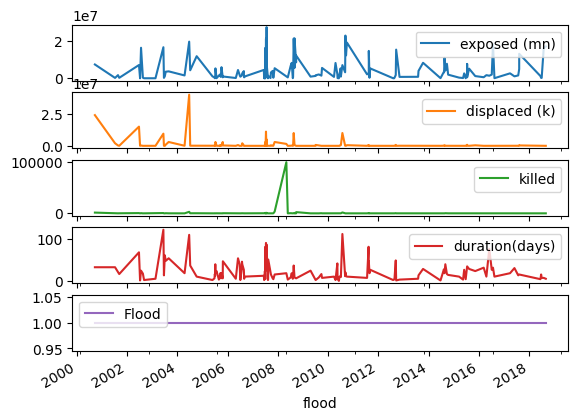

In [3]:
df_floods.plot(subplots=True)

In [4]:
date_range = pd.date_range(start='2000-09-01', end='2018-09-30', freq='D')

# Create a new DataFrame with this date range as the index
final_df = pd.DataFrame(index=date_range)

# Initialize columns in final_df
final_df['Flood'] = 0
final_df['Killed'] = np.nan
final_df['Exposed'] = np.nan  # Initialize 'Exposed' column
final_df['Duration'] = np.nan  # Initialize 'Duration' column

# For each flood event, populate the Flood, killed, exposed, and duration during the flood's duration
for i, row in df_floods.iterrows():
    start_date = i  # 'flood_start' is the index
    end_date = start_date + pd.Timedelta(days=row['duration(days)'] - 1)
    
    # Set Flood = 1, killed, exposed, and duration during the flood period
    final_df.loc[start_date:end_date, 'Flood'] = 1
    final_df.loc[start_date:end_date, 'Killed'] = row['killed']
    final_df.loc[start_date:end_date, 'exposed (mn)'] = row['exposed (mn)']  # Assuming 'exposed' column exists
    final_df.loc[start_date:end_date, 'Duration(days)'] = row['duration(days)']  # Assuming 'duration(days)' exists

# Fill NaN values in Killed, Exposed with 0 (for days with no flood)
final_df['Killed'].fillna(0, inplace=True)
final_df.drop(columns=['Duration','Exposed'],inplace=True)
# Optional: If you want to fill Duration with 0, otherwise leave as NaN

# Display the final DataFrame
final_df.head()

,Flood,Killed,exposed (mn),Duration(days)
2000-09-01,0,0.0,NaN,NaN
2000-09-02,0,0.0,NaN,NaN
2000-09-03,0,0.0,NaN,NaN
2000-09-04,0,0.0,NaN,NaN
2000-09-05,0,0.0,NaN,NaN


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

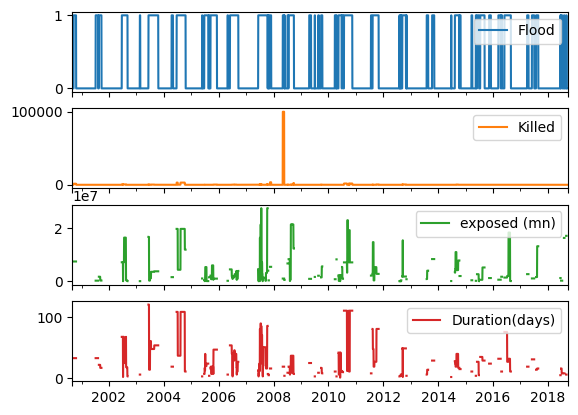

In [5]:
final_df.plot(subplots=True)

In [6]:
df_rain=pd.read_csv(r'open-meteo-24.01N90.00E11m.csv')
df_rain['time'] = pd.to_datetime(df_rain['time'])
df_rain['date'] = df_rain['time'].dt.date
df_rain = df_rain.groupby('date')['rain (mm)'].sum().reset_index()
df_rain.set_index(df_rain['date'],inplace=True)
df_rain.drop(columns=['date'],inplace=True)
df_rain.head()

,rain (mm)
date,
2000-09-01,16.8
2000-09-02,8.7
2000-09-03,11.9
2000-09-04,7.9
2000-09-05,4.1


In [7]:
merged_df = pd.merge(final_df, df_rain, left_index=True, right_index=True, how='left')
merged_df['rain (mm)'].fillna(0, inplace=True)
merged_df.rename(columns={
    'rain (mm)': 'Rain', 
    'killed':'Killed',
    'exposed (mn)':'Exposed',
    'Duration(days)':'Duration'}, inplace=True)

merged_df['KilledPerDay'] = np.where(merged_df['Flood'] > 0, np.nan, 0)
merged_df['ExposedPerDay'] = np.where(merged_df['Flood'] > 0, np.nan, 0)
merged_df.head()
merged_df.head()

,Flood,Killed,Exposed,Duration,Rain,KilledPerDay,ExposedPerDay
2000-09-01,0,0.0,NaN,NaN,16.8,0.0,0.0
2000-09-02,0,0.0,NaN,NaN,8.7,0.0,0.0
2000-09-03,0,0.0,NaN,NaN,11.9,0.0,0.0
2000-09-04,0,0.0,NaN,NaN,7.9,0.0,0.0
2000-09-05,0,0.0,NaN,NaN,4.1,0.0,0.0


In [8]:
for i in tqdm(range(len(df_floods.index))):
    start_date = df_floods.index[i]
    end_date = (start_date+pd.Timedelta(days=df_floods['duration(days)'][i]-1)).date()

    flood_range = pd.date_range(start_date,end_date,freq='D')

    sum_rain = merged_df.loc[flood_range]['Rain'].sum()

    killed = df_floods['killed'][i]
    exposed = df_floods['exposed (mn)'][i]

    rain = merged_df.loc[flood_range]['Rain'].values



    merged_df.loc[flood_range,'KilledPerDay']=(killed/sum_rain)*rain
    merged_df.loc[flood_range,'ExposedPerDay']=(exposed/sum_rain)*rain
    
merged_df.drop(columns=['Exposed', 'Duration','Killed'],inplace=True)

100%|██████████| 147/147 [00:00<00:00, 450.76it/s]


In [9]:
# merged_df.to_csv(r'Main.csv')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

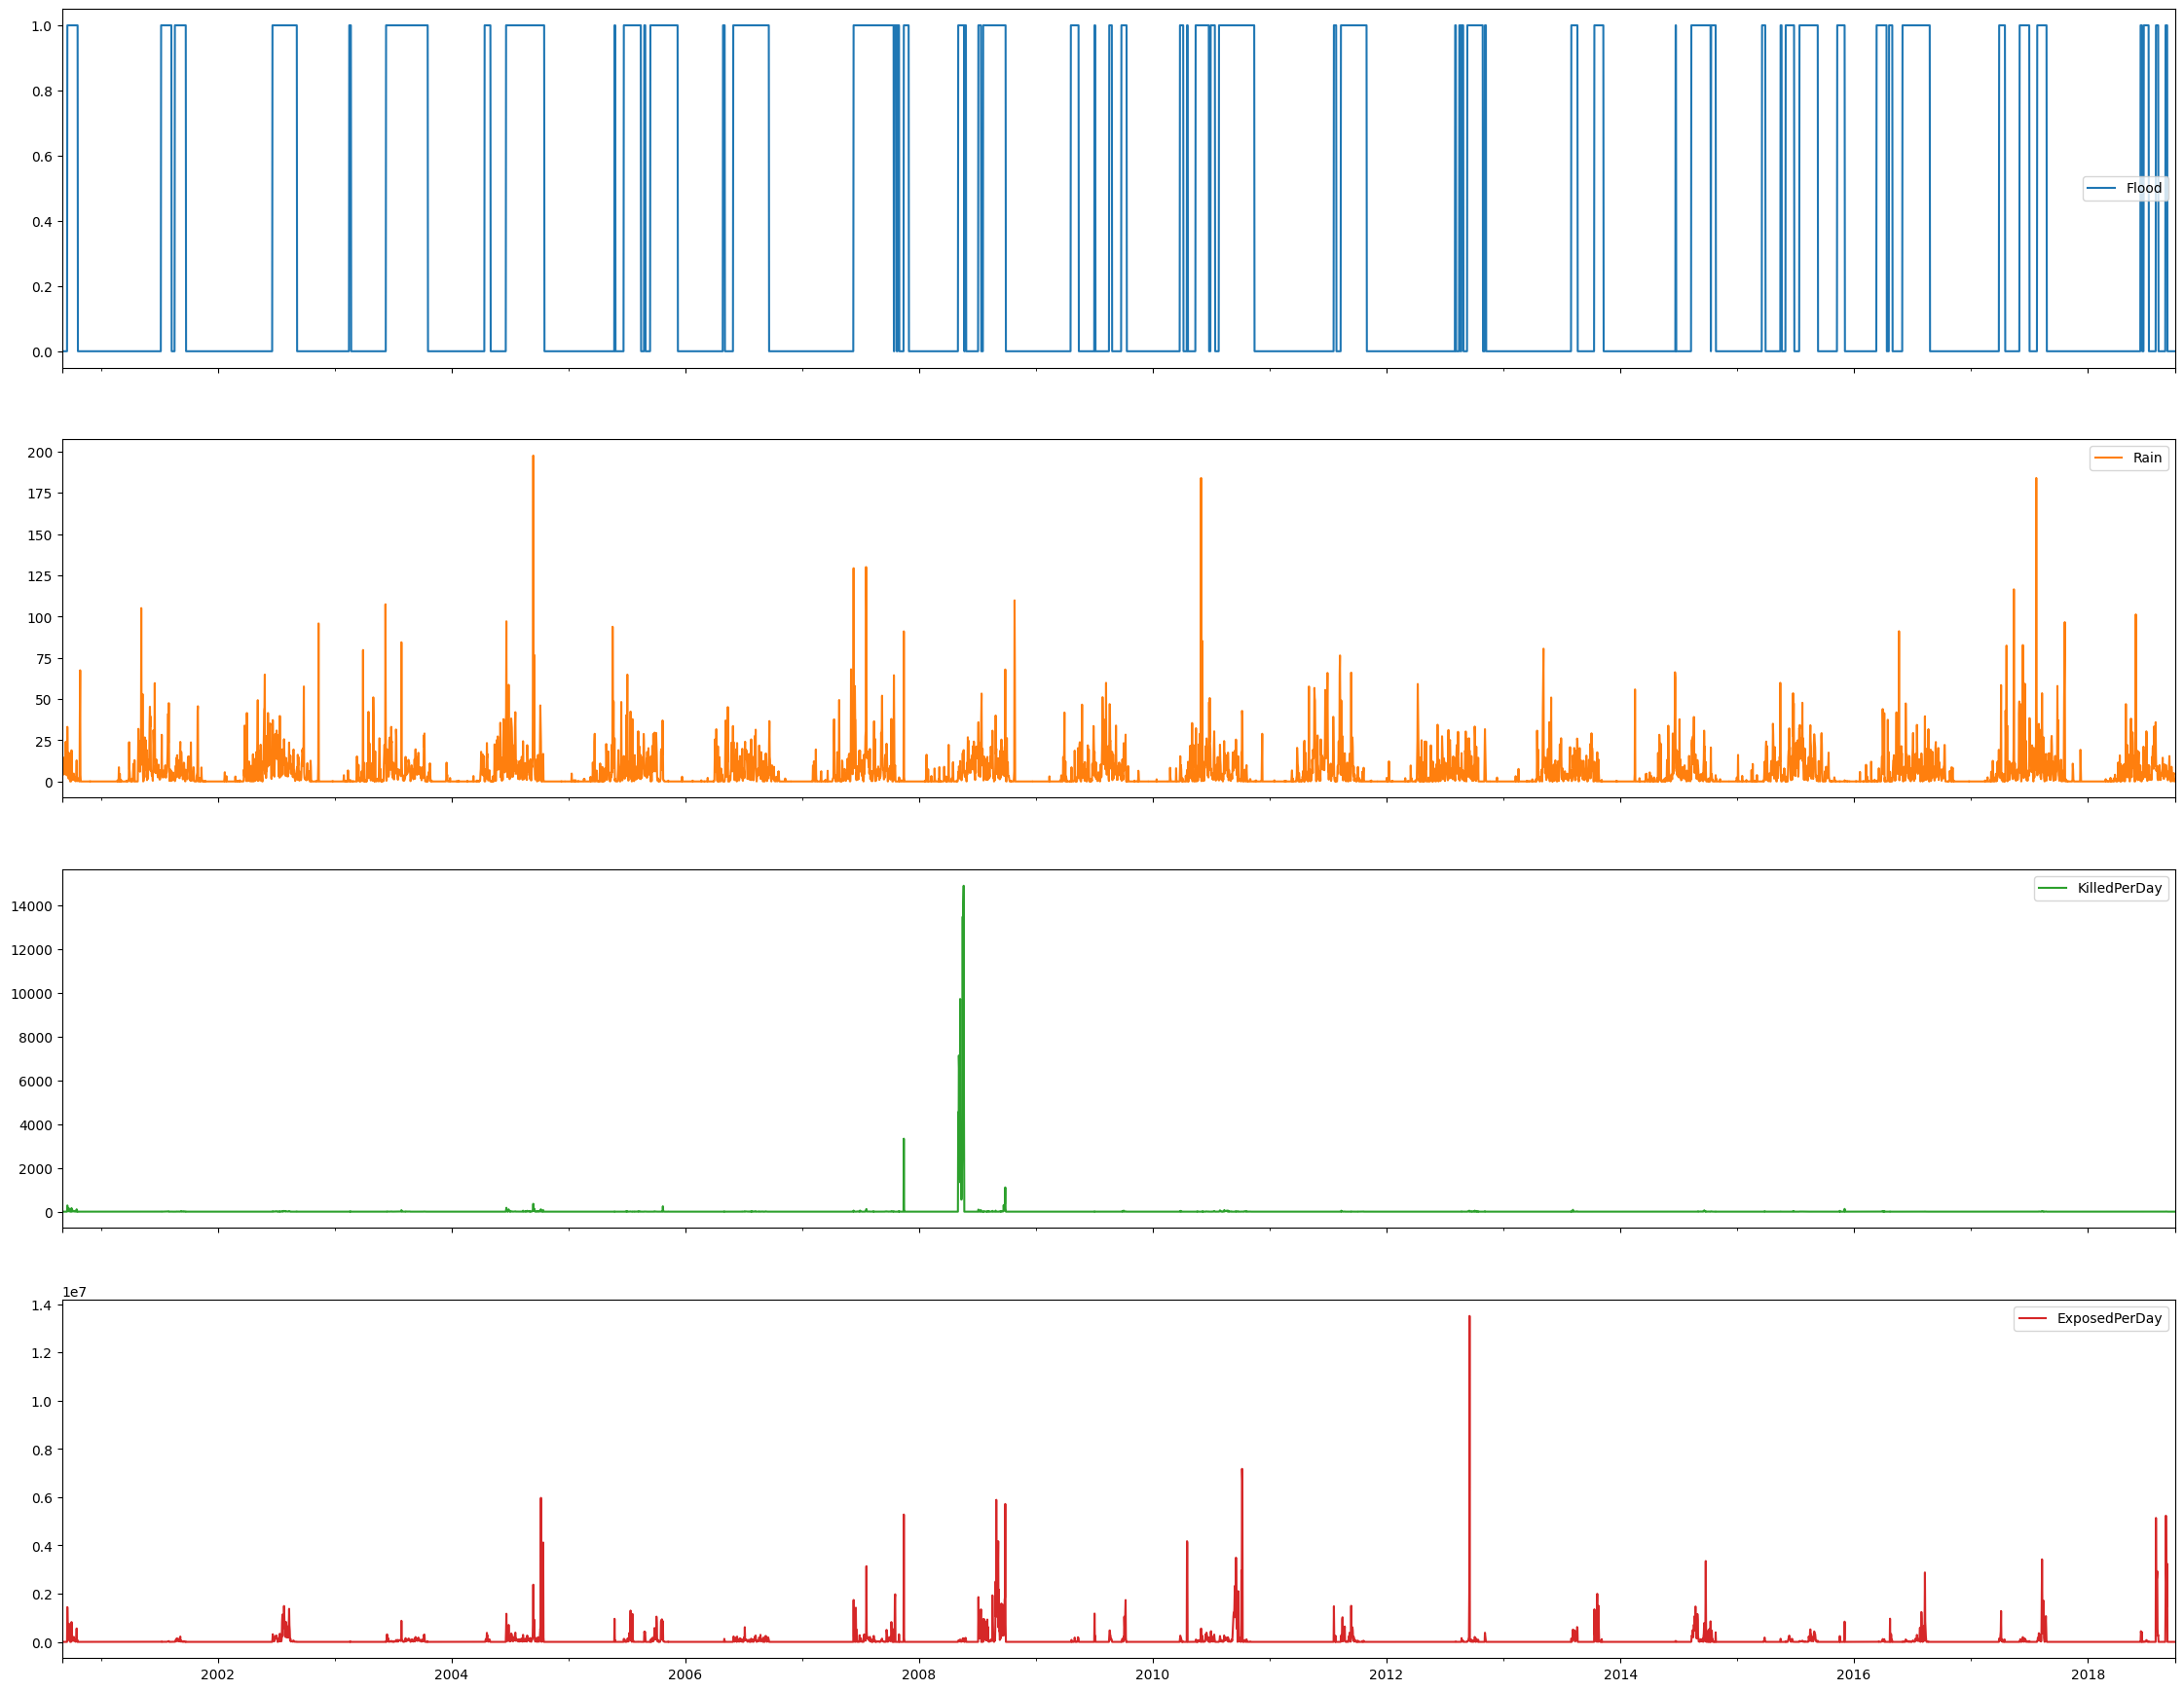

In [10]:
merged_df.plot(subplots=True, figsize=(28,22))

In [11]:
scaled_df = merged_df.copy()
sc = StandardScaler()
scaled_df[['Rain', 'KilledPerDay', 'ExposedPerDay']] = sc.fit_transform(scaled_df[['Rain', 'KilledPerDay', 'ExposedPerDay']])

In [12]:
scaled_df.tail()

,Flood,Rain,KilledPerDay,ExposedPerDay
2018-09-26,0,-0.076587,-0.047737,-0.171694
2018-09-27,0,-0.031995,-0.047737,-0.171694
2018-09-28,0,-0.468994,-0.047737,-0.171694
2018-09-29,0,-0.361974,-0.047737,-0.171694
2018-09-30,0,-0.468994,-0.047737,-0.171694


In [13]:
scaled_df['Flood']=scaled_df['Flood']*10

<Axes: >

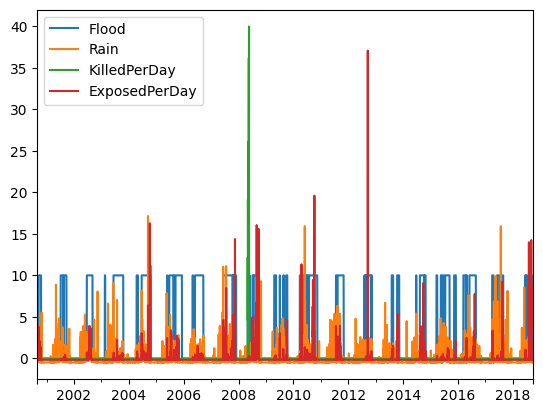

In [14]:
scaled_df.plot()

In [15]:
scaled_df['Flood']=scaled_df['Flood']/10

In [16]:
scaled_df.to_csv('Main.csv')